In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imresize, imread
from tqdm import tqdm_notebook, tnrange
import cv2
from glob import glob
import pickle
import peakutils
from scipy import signal
import imageio
from moviepy.editor import VideoFileClip, ipython_display
from IPython.display import HTML

%matplotlib inline

In [2]:
ROWS = 6
COLS = 9
CAL_IMAGE_SIZE = (720, 1280, 3)
CALC_CAL_POINTS = False
CAL_IMAGE_PATH = 'camera_cal/calibration*.jpg'
CALIBRATION_PATH = 'camera_cal/calibration.p'

def calculate_camera_calibration(path_pattern, rows, cols, image_size):
    objp = np.zeros((rows*cols,3), np.float32)
    objp[:,:2] = np.mgrid[0:cols, 0:rows].T.reshape(-1,2)

    objpoints = []
    imgpoints = []

    images = glob(path_pattern)
    cal_images = np.zeros((len(images), *CAL_IMAGE_SIZE), dtype=np.uint8)

    successfull_cnt = 0
    for idx, fname in enumerate(tqdm_notebook(images, desc='Processing image')):
        img = imread(fname)
        if img.shape[0] != CAL_IMAGE_SIZE[0] or img.shape[1] != CAL_IMAGE_SIZE[1]:
            img = imresize(img, CAL_IMAGE_SIZE)

        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (cols, rows), None) 

        if ret == True:
            successfull_cnt +=1

            objpoints.append(objp)
            imgpoints.append(corners)

            img = cv2.drawChessboardCorners(img, (cols, rows), corners, ret)
            cal_images[idx] = img

    print("%s/%s camera calibration images processed." % (successfull_cnt,len(images)))
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, CAL_IMAGE_SIZE[:-1], None, None)
    
    calibration = {'objpoints': objpoints,
                   'imgpoints': imgpoints,
                   'cal_images': cal_images,
                   'mtx': mtx,
                   'dist': dist,
                   'rvecs': rvecs,
                   'tvecs': tvecs}
    
    return calibration

def get_camera_calibration():
    if CALC_CAL_POINTS:
        calibration = calculate_camera_calibration(CAL_IMAGE_PATH, ROWS, COLS, CAL_IMAGE_SIZE)
        with open(CALIBRATION_PATH, 'wb') as f:
            pickle.dump(calibration, file=f)
    else:
        with open(CALIBRATION_PATH, "rb" ) as f:
            calibration = pickle.load(f)
            
    return calibration;

In [3]:
def cal_undistort(img, calibration):
    objpoints = calibration['objpoints']
    imgpoints = calibration['imgpoints']
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


def abs_sobel_thresh(img_ch, orient='x', sobel_kernel=3, thresh=(0, 255)):  
    if orient == 'x':
        axis = (1, 0)
    elif orient == 'y':
        axis = (0, 1)
    else:
        raise ValueError('orient has to be "x" or "y" not "%s"' % orient)
    
    sobel = cv2.Sobel(img_ch, cv2.CV_64F, *axis)
    abss = np.absolute(sobel)
    
    scale_factor = np.max(abss)/255
    abss = (abss/scale_factor).astype(np.uint8)
    
    binary_output = np.zeros_like(abss)
    binary_output[(abss > thresh[0]) & (abss < thresh[1])] = 1
    
    return binary_output


def mag_thresh(img_ch, sobel_kernel=3, thresh=(0, 255)):    
    sobelx = cv2.Sobel(img_ch, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_ch, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_grad_mag = np.sqrt(sobelx**2+sobely**2)

    scale_factor = np.max(abs_grad_mag)/255
    abs_grad_mag = (abs_grad_mag/scale_factor).astype(np.uint8)
    
    mag_binary = np.zeros_like(abs_grad_mag)
    mag_binary[(abs_grad_mag > thresh[0]) & (abs_grad_mag < thresh[1])] = 1

    return mag_binary


def dir_threshold(img_ch, sobel_kernel=3, thresh=(0, np.pi/2)):    
    sobelx = cv2.Sobel(img_ch, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_ch, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    with np.errstate(divide='ignore', invalid='ignore'):
        abs_grad_dir = np.absolute(np.arctan(sobely/sobelx))
        dir_binary =  np.zeros_like(abs_grad_dir)
        dir_binary[(abs_grad_dir > thresh[0]) & (abs_grad_dir < thresh[1])] = 1

    return dir_binary


def colorspace_channel_select(img, cs, ch, thresh=(0, 255)):
    cs_img = cv2.cvtColor(img, cs)
    s_ch = cs_img[:,:,ch]
    retval, ch_binary = cv2.threshold(s_ch.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)

    return ch_binary


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def push_higlights(img, thres=200):
    img[img > thres] = 255
    return img

def extract_yellow(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (20, 100, 100), (30, 255, 255))
    
    return mask

def extract_white(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (0, 0, 200), (255, 30, 255))
    
    return mask

def get_thresholded_image(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    s_binary = colorspace_channel_select(img,  cv2.COLOR_RGB2HLS, 2, thresh=(150, 255))

    gradx = abs_sobel_thresh(v_channel, orient='x', sobel_kernel=11, thresh=(30, 255))   
    grady = abs_sobel_thresh(v_channel, orient='y', sobel_kernel=11, thresh=(30, 255))
    x_and_y = (grady & gradx)
    
    mag_binary = mag_thresh(v_channel, sobel_kernel=11, thresh=(30, 255)) 
    dir_binary = dir_threshold(v_channel, sobel_kernel=5, thresh=(np.pi/5, np.pi/2.3))
    
    
    gamma = adjust_gamma(img, .1)
    gamma = np.mean(gamma, 2)
    _, gamma = cv2.threshold(gamma.astype(np.uint8), 50, 255, cv2.THRESH_BINARY)
    wht = extract_white(img)
    ylw = extract_yellow(img)
    img = np.dstack([gamma, wht, ylw])

    mask = (x_and_y == 1.) | ((mag_binary * dir_binary) == 1.)
    mask = (mask * 255).astype(np.uint8)
    img = np.dstack([gamma, wht, ylw])
    img = np.max(img, axis=2)
    
    return img


class PerspectiveTransformer():
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.M_inv = cv2.getPerspectiveTransform(dst, src)

    def transform(self, img):
        return cv2.warpPerspective(img, self.M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    
    def inverse_transform(self, img):
        return cv2.warpPerspective(img, self.M_inv, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)

def histogram_lane_detection(img, steps, search_window, h_window, v_window):
    all_x = []
    all_y = []
    masked_img = img[:, search_window[0]:search_window[1]]
    histograms = np.zeros((steps, masked_img.shape[1]))
    pixels_per_step = img.shape[0]//steps
    
    for i in range(steps):    
        start = masked_img.shape[0] - (i * pixels_per_step)
        end = start - pixels_per_step
        histogram = np.sum(masked_img[end:start,:], axis=0)
        histograms[i] = histogram
    
    histograms = histogram_smoothing(histograms, window=v_window)
    
#     fig, axis = plt.subplots(steps, sharey=True, sharex=True)
    for i, histogram in enumerate(histograms):
        start = masked_img.shape[0] - (i * pixels_per_step)
        end = start - pixels_per_step
        
        histogram_smooth = signal.medfilt(histogram, h_window)        
        peaks = np.array(signal.find_peaks_cwt(histogram_smooth, np.arange(1, 50)))
        
        highest_peak = detect_highest_peak_in_area(histogram_smooth, peaks, threshold=1000)
        if highest_peak is not None:
            center = (start + end)//2
            x, y = get_pixel_in_window(masked_img, highest_peak, center, pixels_per_step)

            all_x.extend(x)
            all_y.extend(y)
            
#         axis[i].plot(histogram_smooth)
#         axis[i].get_yaxis().set_visible(False)

#     plt.show()
    
    all_x = np.array(all_x) + search_window[0]
    all_y = np.array(all_y)

    return all_x, all_y

def highest_n_peaks(histogram, peaks, n=2, threshold=0):
    if len(peaks) == 0:
        return []
    
    peak_list = []
    for peak in peaks:
        y = histogram[peak]
        if y > threshold:
            peak_list.append((peak, histogram[peak]))   
    peak_list = sorted(peak_list, key=lambda x: x[1], reverse=True)

    if len(peak_list) == 0:
        return []
    else:
        x, y = zip(*peak_list)
        return x[:n]

def histogram_smoothing(histograms, window=3):
    smoothed = np.zeros_like(histograms)
    for h_i, hist in enumerate(histograms):
        window_sum = np.zeros_like(hist)
        for w_i in range(window):
            index = w_i + h_i - window//2
            if index < 0:
                index = 0
            elif index > len(histograms) - 1:
                index = len(histograms) - 1
            
            window_sum += histograms[index]
        
        smoothed[h_i] = window_sum / window
        
    return smoothed

def detect_highest_peak_in_area(histogram, peaks, threshold=0):
    peak = highest_n_peaks(histogram, peaks, n=1, threshold=threshold)
    if len(peak) == 1:
        return peak[0]
    else: 
        return None

def detect_lane_along_poly(img, poly, steps):
    pixels_per_step = img.shape[0]//steps
    all_x = []
    all_y = []
    
    for i in range(steps):
        start = img.shape[0] - (i * pixels_per_step)
        end = start - pixels_per_step
        
        center = (start + end)//2
        x = poly(center)
        
        x, y = get_pixel_in_window(img, x, center, pixels_per_step)
        
        all_x.extend(x)
        all_y.extend(y)
        
    return all_x, all_y

def get_pixel_in_window(img, x_center, y_center, size):
    half_size = size//2
    window = img[y_center-half_size:y_center+half_size,
                 x_center-half_size:x_center+half_size]
    
    x, y = (window.T==255).nonzero()

    x = x + x_center-half_size
    y = y + y_center-half_size
    
    return x, y

def calculate_lane_area(lanes, img_height, steps):
    """
    Expects the line polynom to be a function of y.
    """
    points_left = np.zeros((steps + 1, 2))
    points_right = np.zeros((steps + 1, 2))

    for i in range(steps + 1):
        pixels_per_step = img_height//steps
        start = img_height - i * pixels_per_step

        points_left[i] = [lanes[0].best_fit_poly(start), start]
        points_right[i] = [lanes[1].best_fit_poly(start), start]

    return np.concatenate((points_left, points_right[::-1]), axis=0)

def are_lanes_plausible(lane_one, lane_two, parall_thres=(0.0003, 1), dist_thres=(300, 600)):
    is_parall = lane_one.is_current_fit_parallel(lane_two, threshold=parall_thres)
    dist = lane_one.get_current_fit_distance(lane_two)
    is_plausible_dist = dist_thres[0] < dist < dist_thres[1]
#     print('lane_one', lane_one.best_fit_poly)
#     print('lane_two', lane_two.best_fit_poly)
#     print('dif', lane_one.best_fit_poly - lane_two.best_fit_poly)

#     print('is_parall', is_parall)
#     print('is_plausible_dist', is_plausible_dist)
    return is_parall & is_plausible_dist


def draw_poly(img, poly, steps, color):
    img_height = img.shape[0]
    pixels_per_step = img_height//steps    
    
    for i in range(steps):    
        start = i * pixels_per_step
        end = start + pixels_per_step
        
        start_point = (int(poly(start)), start)
        end_point = (int(poly(end)), end)

        img = cv2.line(img, start_point, end_point, color, 10)
    
    return img

In [4]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, n_frames=1, x=None, y=None):
        # Frame memory
        self.n_frames = n_frames
        # was the line detected in the last iteration?
        self.detected = False
        # number of pixels added per frame
        self.n_pixel_per_frame = []
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = None
        #Polynom for the current coefficients
        self.current_fit_poly = None
        #Polynom for the average coefficients over the last n iterations
        self.best_fit_poly = None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        if x is not None:
            self.update(x, y)
        
    def update(self, x, y):
        assert len(x) == len(y), 'x and y have to be the same size'
        
        self.allx = x
        self.ally = y
        
        self.n_pixel_per_frame.append(len(self.allx))
        self.recent_xfitted.extend(self.allx)
        
        if len(self.n_pixel_per_frame) > self.n_frames:
            n_x_to_remove = self.n_pixel_per_frame.pop(0)
            self.recent_xfitted = self.recent_xfitted[n_x_to_remove:]
        
        self.bestx = np.mean(self.recent_xfitted)
        
        self.current_fit = np.polyfit(self.allx, self.ally, 2)
        
        if self.best_fit is None:
            self.best_fit = self.current_fit
        else:
            self.best_fit = (self.best_fit * (self.n_frames - 1) + self.current_fit) / self.n_frames
            
        self.current_fit_poly = np.poly1d(self.current_fit)
        self.best_fit_poly = np.poly1d(self.best_fit)

    
    def is_current_fit_parallel(self, other_line, threshold=(0, 0)):        
        first_coefi_dif = np.abs(self.current_fit[0] - other_line.current_fit[0])
        second_coefi_dif = np.abs(self.current_fit[1] - other_line.current_fit[1])
        
        return first_coefi_dif < threshold[0] and second_coefi_dif < threshold[1]
        
    def get_current_fit_distance(self, other_line):
        return np.abs(self.current_fit[2] - other_line.current_fit[2])

In [122]:
HIST_STEPS = 10
OFFSET = 200
SRC = np.float32([
    (300, 720),
    (580, 470),
    (730, 470),
    (1100, 720)])


DST = np.float32([
    (SRC[0][0] + OFFSET, SRC[0][1]),
    (SRC[0][0] + OFFSET, 0),
    (SRC[-1][0] - OFFSET, 0),
    (SRC[-1][0] - OFFSET, SRC[0][1])])

FRAME_MEMORY = 5

class LaneDetector():
    def __init__(self, perspective_src, perspective_dst, n_frames=1, cam_calibration=None, line_segments=10):
        # Frame memory
        self.n_frames = n_frames
        self.cam_calibration = cam_calibration
        self.line_segments = line_segments
        
        self.left_line = Line(n_frames)
        self.right_line = Line(n_frames)
        
        self.perspective_src = perspective_src
        self.perspective_dst = perspective_dst
        self.perspective_transformer = PerspectiveTransformer(perspective_src, perspective_dst)
        
        self.n_frames_processed = 0

        
    def process_frame(self, frame):
        orig_frame = np.copy(frame)
        
        # Apply the distortion correction to the raw image.
        if cam_calibration is not None:
            frame = cal_undistort(frame, self.cam_calibration)
    
        # Use color transforms, gradients, etc., to create a thresholded binary image.
        frame = gaussian_blur(frame, kernel_size=5)
        frame = get_thresholded_image(frame)
        
        # Apply a perspective transform to rectify binary image ("birds-eye view").
        frame = self.perspective_transformer.transform(frame)
        
        # mask outside are of persp trans
        frame[:, frame.shape[1]-OFFSET:] = 0
        frame[:, :OFFSET] = 0
        
        try:
            if self.n_frames_processed != 0:
                left_x, left_y = detect_lane_along_poly(frame, self.left_line.best_fit_poly, self.line_segments)
                right_x, right_y = detect_lane_along_poly(frame, self.right_line.best_fit_poly, self.line_segments)

                if len(left_x) == 0 or len(right_x) == 0:
                    lines_detected = False
                else:
                    left_x, left_y = outlier_removal(left_x, left_y)
                    right_x, right_y = outlier_removal(right_x, right_y)
                    new_left = Line(y=left_x, x=left_y)
                    new_right = Line(y=right_x, x=right_y)
                    #print('\n simple search')
                    lines_detected = are_lanes_plausible(new_left, new_right)
            else:
                lines_detected = False

            if lines_detected == False:
                left_x, left_y = histogram_lane_detection(
                    frame, self.line_segments, (OFFSET, frame.shape[1]//2), h_window=21, v_window=3)
                right_x, right_y = histogram_lane_detection(
                    frame, self.line_segments, (frame.shape[1]//2, frame.shape[1] - OFFSET), h_window=21, v_window=3)

                if len(left_x) == 0 or len(right_x) == 0:
                    lines_detected = False
                else:
                    left_x, left_y = outlier_removal(left_x, left_y)
                    right_x, right_y = outlier_removal(right_x, right_y)
                    new_left = Line(y=left_x, x=left_y)
                    new_right = Line(y=right_x, x=right_y)
                    #print('\n blind search')
                    lines_detected = are_lanes_plausible(new_left, new_right)

            if lines_detected == True or self.n_frames_processed == 0:
                # switch x and y since lines are almost vertical
                self.left_line.update(y=left_x, x=left_y)
                # switch x and y since lines are almost vertical
                self.right_line.update(y=right_x, x=right_y)
        except:
            print('ups')
            
        top_view = np.zeros_like(orig_frame)
        mask = np.zeros_like(frame)    
        lane_area = calculate_lane_area((self.left_line, self.right_line), frame.shape[0], self.line_segments)
        mask = cv2.fillPoly(mask, np.int32([lane_area]), 255)
        mask = self.perspective_transformer.inverse_transform(mask)

        orig_frame[mask == 255, 1] = 255
        
        self.n_frames_processed += 1
        
#         top_view = np.dstack((frame, frame, frame))
#         lines_best = np.zeros_like(frame)   
#         lines_best = draw_poly(lines_best, self.left_line.best_fit_poly, 10, 255)
#         lines_best = draw_poly(lines_best, self.right_line.best_fit_poly, 10, 255)
#         lines_best = self.perspective_transformer.inverse_transform(lines_best)
#         orig_frame[lines_best == 255] = (255,0,0)

#         lines = np.zeros_like(frame)   
#         lines = draw_poly(lines, self.left_line.current_fit_poly, 10, 255)
#         lines = draw_poly(lines, self.right_line.current_fit_poly, 10, 255)
#         lines = self.perspective_transformer.inverse_transform(lines)
#         orig_frame[lines == 255] = (0,0,255)
        
#         orig_frame[(lines == 255) & (lines_best == 255)] = (255,0,255)
        
#         plt.imshow(frame, cmap="gray")
#         plt.show()
        
        return orig_frame

In [123]:
def outlier_removal(x, y, q=10):
    x = np.array(x)
    y = np.array(y)

    lower_bound = np.percentile(x, q)
    upper_bound = np.percentile(x, 100-q)
    selection = (x >= lower_bound) & (x <= upper_bound)
    return x[selection], y[selection]

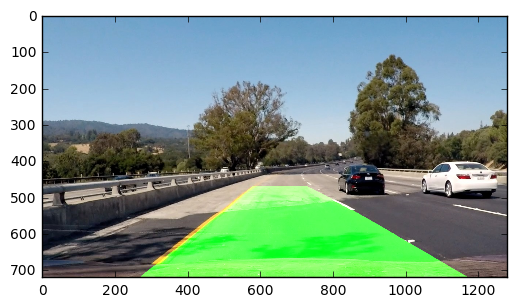

In [124]:
cam_calibration = get_camera_calibration()
ld = LaneDetector(SRC, DST, n_frames=FRAME_MEMORY, cam_calibration=cam_calibration)

img = imread('test_images/test4.jpg')

for i in range(1):
    img = ld.process_frame(img)


plt.imshow(img, cmap='gray')

In [125]:
images = []
for i in range(1, 11):
    images.append(imread('test_images/test%s.jpg' % i))

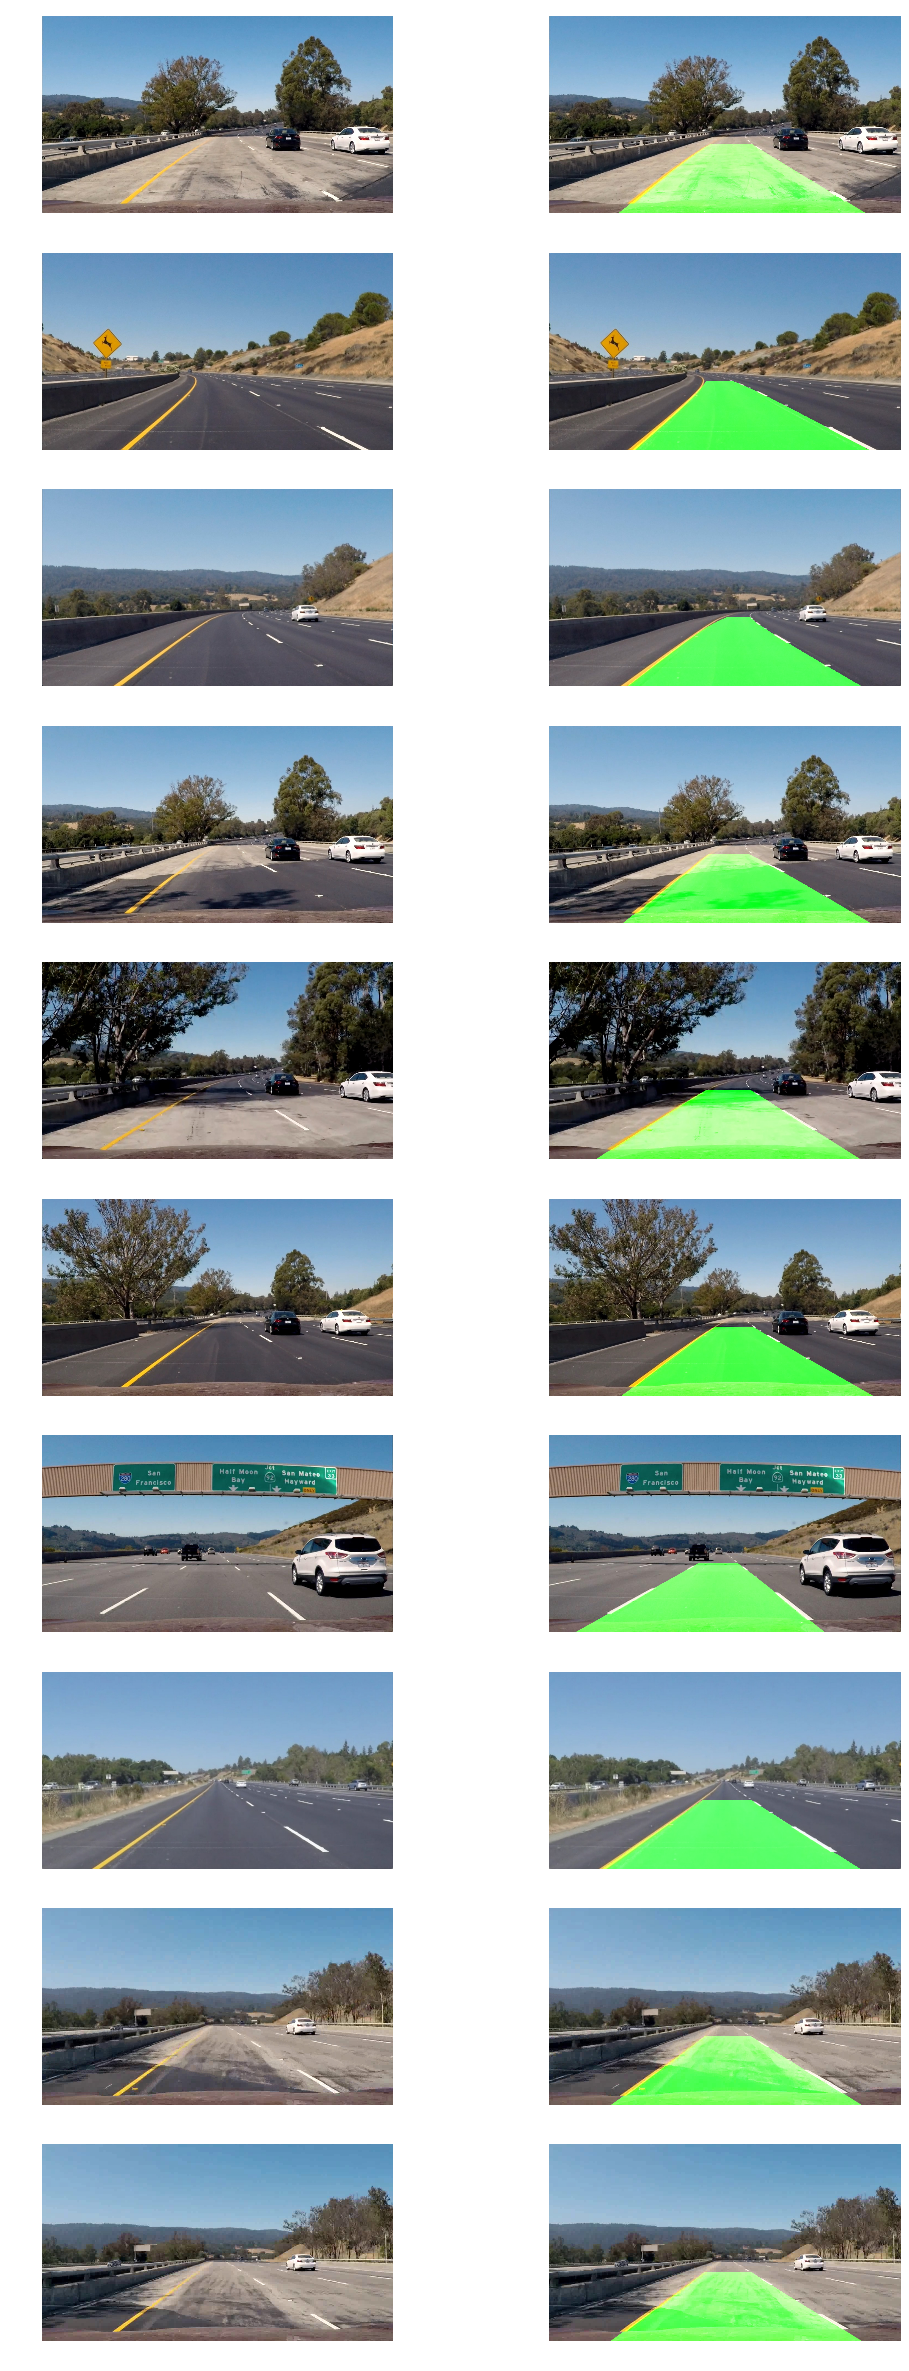

In [126]:
cam_calibration = get_camera_calibration()
rows=10
cols=2
fig, axis = plt.subplots(rows, cols, figsize=(12, 3*rows))
for row in range(rows):
    img = images[row]

    axis[row, 0].imshow(img, cmap='gray')
    axis[row, 0].axis('off')
    
    ld = LaneDetector(SRC, DST, n_frames=FRAME_MEMORY, cam_calibration=cam_calibration)
    try:
        img = ld.process_frame(img)
    except:
        img= img
    axis[row, 1].imshow(img, cmap='gray')
    axis[row, 1].axis('off')

In [127]:
cam_calibration = get_camera_calibration()
ld = LaneDetector(SRC, DST, n_frames=FRAME_MEMORY, cam_calibration=cam_calibration)

project_output = 'short_ann.mp4'
clip1 = VideoFileClip("short.mp4")
project_clip = clip1.fl_image(ld.process_frame)
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video short_ann.mp4
[MoviePy] Writing video short_ann.mp4








  0%|          | 0/135 [00:00<?, ?it/s]





  1%|          | 1/135 [00:00<01:41,  1.32it/s]





  1%|▏         | 2/135 [00:01<01:41,  1.32it/s]





  2%|▏         | 3/135 [00:02<01:40,  1.32it/s]





  3%|▎         | 4/135 [00:03<01:52,  1.16it/s]





  4%|▎         | 5/135 [00:04<01:47,  1.21it/s]





  4%|▍         | 6/135 [00:04<01:44,  1.24it/s]





  5%|▌         | 7/135 [00:05<01:41,  1.26it/s]





  6%|▌         | 8/135 [00:06<01:39,  1.28it/s]





  7%|▋         | 9/135 [00:07<01:37,  1.29it/s]





  7%|▋         | 10/135 [00:07<01:35,  1.30it/s]





  8%|▊         | 11/135 [00:08<01:34,  1.31it/s]





  9%|▉         | 12/135 [00:09<01:33,  1.32it/s]





 10%|▉         | 13/135 [00:10<01:32,  1.32it/s]





 10%|█         | 14/135 [00:10<01:31,  1.32it/s]





 11%|█         | 15/135 [00:11<01:30,  1.32it/s]





 12%|█▏        | 16/135 [00:12<01:29,  1.33it/s]





 13%|█▎        | 17/135 [00:13<01:28,  1.33it/s]





 13%|█▎        | 18/135 [00:13<01:29,  1

[MoviePy] Done.
[MoviePy] >>>> Video ready: short_ann.mp4 

CPU times: user 3min 37s, sys: 3.84 s, total: 3min 41s
Wall time: 1min 48s


CPU times: user 3min 52s, sys: 3.43 s, total: 3min 56s
Wall time: 2min 2s

In [128]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [89]:
cam_calibration = get_camera_calibration()
ld = LaneDetector(SRC, DST, n_frames=FRAME_MEMORY, cam_calibration=cam_calibration)

project_output = 'project_video_ann.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(ld.process_frame)
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_ann.mp4
[MoviePy] Writing video project_video_ann.mp4









  0%|          | 0/1261 [00:00<?, ?it/s]






  0%|          | 1/1261 [00:01<26:06,  1.24s/it]






  0%|          | 2/1261 [00:02<26:47,  1.28s/it]






  0%|          | 3/1261 [00:03<24:23,  1.16s/it]






  0%|          | 4/1261 [00:04<22:08,  1.06s/it]






  0%|          | 5/1261 [00:05<20:55,  1.00it/s]






  0%|          | 6/1261 [00:05<19:30,  1.07it/s]






  1%|          | 7/1261 [00:06<18:28,  1.13it/s]






  1%|          | 8/1261 [00:08<21:00,  1.01s/it]






  1%|          | 9/1261 [00:08<19:23,  1.08it/s]






  1%|          | 10/1261 [00:09<18:16,  1.14it/s]






  1%|          | 11/1261 [00:10<17:28,  1.19it/s]






  1%|          | 12/1261 [00:11<17:03,  1.22it/s]






  1%|          | 13/1261 [00:12<20:49,  1.00s/it]






  1%|          | 14/1261 [00:13<19:49,  1.05it/s]






  1%|          | 15/1261 [00:14<18:32,  1.12it/s]






  1%|▏         | 16/1261 [00:14<17:53,  1.16it/s]






  1%|▏         | 17/1261 [00:15<17:35,  1.18it/s]






  1

ups









 97%|█████████▋| 1218/1261 [18:14<00:41,  1.04it/s]






 97%|█████████▋| 1219/1261 [18:15<00:44,  1.07s/it]






 97%|█████████▋| 1220/1261 [18:17<00:53,  1.30s/it]






 97%|█████████▋| 1221/1261 [18:19<00:59,  1.49s/it]






 97%|█████████▋| 1222/1261 [18:21<00:56,  1.46s/it]






 97%|█████████▋| 1223/1261 [18:22<00:52,  1.38s/it]






 97%|█████████▋| 1224/1261 [18:23<00:49,  1.33s/it]






 97%|█████████▋| 1225/1261 [18:24<00:46,  1.29s/it]






 97%|█████████▋| 1226/1261 [18:25<00:43,  1.26s/it]






 97%|█████████▋| 1227/1261 [18:27<00:42,  1.24s/it]






 97%|█████████▋| 1228/1261 [18:28<00:40,  1.22s/it]






 97%|█████████▋| 1229/1261 [18:29<00:38,  1.22s/it]






 98%|█████████▊| 1230/1261 [18:30<00:37,  1.21s/it]






 98%|█████████▊| 1231/1261 [18:31<00:36,  1.20s/it]






 98%|█████████▊| 1232/1261 [18:33<00:35,  1.23s/it]






 98%|█████████▊| 1233/1261 [18:34<00:34,  1.25s/it]






 98%|█████████▊| 1234/1261 [18:35<00:34,  1.27s/it]






 98%|██

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_ann.mp4 

CPU times: user 34min 39s, sys: 29.9 s, total: 35min 9s
Wall time: 19min 6s


In [90]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))